In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
import os.path
from datetime import datetime, timezone
import shutil
import cv2
from autopipy.cvObjectDetectors import ArenaDetector
from autopipy.dlcObjectDetectors import MouseLEDsDetector

/home/kilo/repo/analysis_jingjie/jingjie/autopi_mec_jingjie/autopi_mec/mouse_and_objects_position_tracking/setup_project.py:769: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/home/kilo/repo/analysis_jingjie/jingjie/autopi_mec_jingjie/autopi_mec/mouse_and_objects_position_tracking/setup_project.py:797: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()


Loading DLC 2.2.3...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists()

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /adata/projects/autopi_mec
dlcModelPath: /adata/models
Reading /adata/projects/autopi_mec/sessionList_invalid
We have 1 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
def prepareSessionsForSpatialAnalysisProject(sSessions):
    print("Loading Animal_pose and Spike_train, sSes.ap and sSes.cg")
    for ses in tqdm(sSessions):
        ses.load_parameters_from_files() 
        ap = Animal_pose(ses)
        ses.ap = ap
        
prepareSessionsForSpatialAnalysisProject(sSessions)

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|██████████| 1/1 [00:00<00:00, 1119.38it/s]


In [4]:
def get_all_ros_res_times_positrack2(ses,ap,ext):
    """
    Get the ros and res times for all the positrack2 frames.
    Works for sessions in which positrack2 was used.
    """
    # iterate for trials 
    all_ros_res_times = np.empty(shape=(0,2))

    for i,t in enumerate(ap.ses.trial_names):
        positrack_file_name = ap.ses.path + "/" + t+"."+ ext
        pt = pd.read_csv(positrack_file_name)
        tNo = int(t[-1]) # get the trial number
        res = ap.ttl_ups[tNo-1] 
        ros = pt.acq_time_source_0
        ar = np.vstack([ros,res]).T
        all_ros_res_times = np.vstack([all_ros_res_times,ar])
        print(len(pt),len(ros),all_ros_res_times.shape)
    return all_ros_res_times

def interpolate_pose_ros_times(ap,all_ros_res_times):
    """
    Get the ROS time of all rows in the Animal_pose.pose array
    
    We have the ROS time and res time of all rows of the positrack file.
    We just need to interpolate to get the ROS time at fixed intervals (rows in Animal_pose.pose have a fixed intervals)
    """
    res = ap.pose[:,0]*ses.sampling_rate
    print("res time:",np.min(res),np.max(res))
    fx = interp1d(all_ros_res_times[:,1], all_ros_res_times[:,0], bounds_error=False) # x we will start at 0 until the end of the file
    ros_times = fx(res)
    print("ROS time:",np.nanmin(ros_times),np.nanmax(ros_times),"Ros duration (sec):", np.nanmax(ros_times)-np.nanmin(ros_times))
    return ros_times

def add_ros_time_to_pose(ses,pose_file_extension = ".pose.npy"):
    
    ses.load_parameters_from_files()
    print(ses.name)
    ext = "positrack2_post"
    print(ext)
    ap = ses.ap
    ap.load_pose_from_file(verbose=False,pose_file_extension = pose_file_extension)
    ap.load_ttl_ups_files()

    fn = ses.path+"/"+ses.trial_names[0]+"." +ext
    print("Reading",fn)
    pt = pd.read_csv(fn)

    all_ros_res_times = get_all_ros_res_times_positrack2(ses,ap,ext=ext)

    plt.plot(all_ros_res_times[:,0],all_ros_res_times[:,1])
    print(np.nanmin(all_ros_res_times[:,0]),np.nanmax(all_ros_res_times[:,0]))
    print(np.nanmin(all_ros_res_times[:,1]),np.nanmax(all_ros_res_times[:,1]))


    ros_times = interpolate_pose_ros_times(ap,all_ros_res_times)
    print(ap.pose.shape,ros_times.shape)

    def rosTimeToDateTime(rt):
        return datetime.fromtimestamp(rt,tz=timezone.utc)

    print(ses.name,ses.path)
    log = pd.read_csv(ses.path+"/"+ses.name+".log",sep=" ")
    #lp_times = log.time[log.event=="leverPress"].to_numpy()
    lp_times = log.time.to_numpy()
    lp_time_min=rosTimeToDateTime(np.min(lp_times))
    lp_time_max=rosTimeToDateTime(np.max(lp_times))

    print("task log file events from :",lp_time_min ,"to",lp_time_max)
    print(np.min(lp_times),np.max(lp_times))
    pose_time_min=rosTimeToDateTime(np.nanmin(ros_times))
    pose_time_max=rosTimeToDateTime(np.nanmax(ros_times))
    print("positrack file from :",pose_time_min ,"to",pose_time_max)
    print(np.nanmin(ros_times),np.nanmax(ros_times))

    ap.pose_ori = np.hstack([ap.pose_ori[:,0:7],np.expand_dims(ros_times,1)])
    ap.save_pose_to_file()

    ap.load_pose_from_file(verbose=True)
    if ap.pose_ori.shape[1] != 8:
        print("!!!!Problem with the shape of the ap.pose {}!!!!".format(ap.pose_ori.shape))

    r=40
    plt.figure(figsize=(10,10))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(ap.pose_ori[:,1],ap.pose_ori[:,2])
    pt = np.arange(0,2*np.pi,0.01)
    plt.plot(np.cos(pt)*r,np.sin(pt)*r,c="red")
    plt.show()

def animal_pose_pose_interpolate_small_gaps(ap,limit=5):
    """
    Use linear interpolation to fill small gaps in the pose array.
    
    For small gaps, this method is probably more appropriate than using data from a different camera. That is why we apply it at this stage.
    
    Arguments
    ap: SpikeA.Animal_pose
    limits: how many np.nan samples to interpolate
    """
    sx = pd.Series(ses.ap.pose[:,1])
    sy = pd.Series(ses.ap.pose[:,2])
    sx = sx.interpolate(limit=limit)
    sy = sy.interpolate(limit=limit)
    ses.ap.pose[:,1] = sx.to_numpy()
    ses.ap.pose[:,2] = sy.to_numpy()
    
def plot_pose(ses):
    plt.plot(ses.ap.pose[:,1],ses.ap.pose[:,2])
    plt.show()

In [5]:
def generate_animal_pose_pose(ses):
    ses.ap.pose_from_positrack_files(extension= "positrack2_post", use_previous_up_detection=True,transform_to_cm=False)
    plot_pose(ses)
    animal_pose_pose_interpolate_small_gaps(ses.ap,limit=5)
    ses.ap.save_pose_to_file()
    add_ros_time_to_pose(ses,pose_file_extension = ".pose.npy")

Interpolation step: 400.0 samples

Loop through 7 trials

/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.dat
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post
Getting ttl pulses time from /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.ttl_up.npy
Number of ttl pulses detected: 54047
Number of lines in positrack file: 54047
start tracking at: 5.7608 sec
last ttl to end of dat file duration: 5.9292 sec
hdRange: 6.283075653879415
Invalid values: 941
Valid values: 53106
Percentage of invalid values: 1.74%

/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.dat
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.positrack2_post
Getting ttl pulses time from /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.ttl_up.npy
Number of ttl pulses detected: 18029
Number of lines in positrack file: 18029
start tracking at: 5.8163 sec
last ttl 

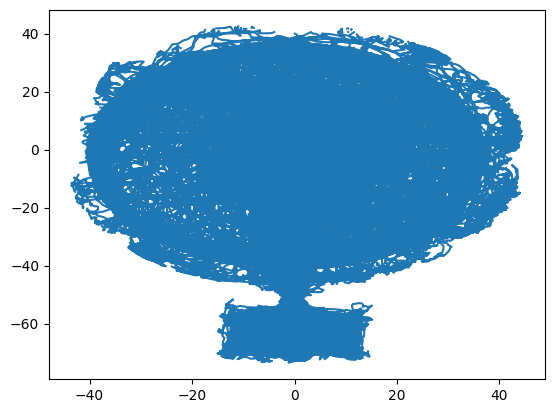

Saving original pose (shape: (499511, 7)) to /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021-0107.pose.npy
mn8578-30112021-0107
positrack2_post
Reading /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post
54047 54047 (54047, 2)
18029 18029 (72076, 2)
54051 54051 (126127, 2)
54068 54068 (180195, 2)
54037 54037 (234232, 2)
9027 9027 (243259, 2)
54041 54041 (297300, 2)
1638263295.580526 1638273984.2443635
115216.0 199687626.0
res time: 0.0 199804000.0
ROS time: 1638263295.605176 1638273984.242001 Ros duration (sec): 10688.636825084686
(499511, 7) (499511,)
mn8578-30112021-0107 /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107
task log file events from : 2021-11-30 09:54:10.694124+00:00 to 2021-11-30 11:27:57.937270+00:00
1638266050.694124 1638271677.93727
positrack file from : 2021-11-30 09:08:15.605176+00:00 to 2021-11-30 12:06:24.242001+00:00
1638263295.605176 1638273984.242001
Saving original pose (shape: (499511, 8)) to 

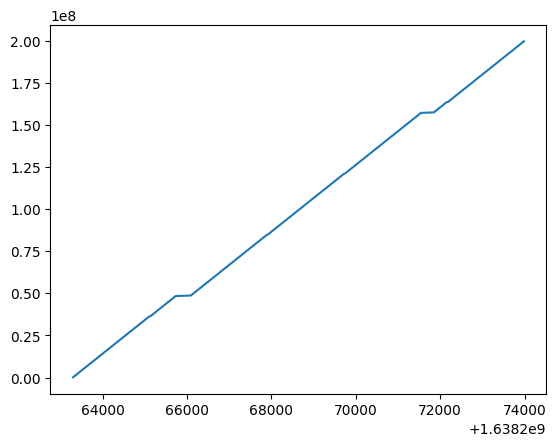

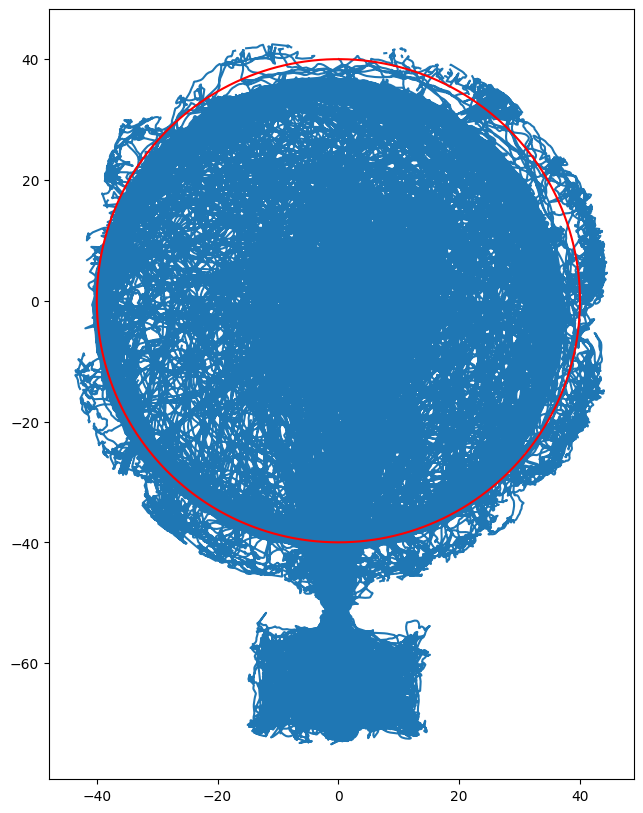

In [7]:
ses = sSessions[0]
#ses.ap.pose_from_positrack_files(extension= "positrack2_post", use_previous_up_detection=True,transform_to_cm=False)
generate_animal_pose_pose(ses)

****** 0 mn8578-30112021-0107 **********
Interpolation step: 400.0 samples

Loop through 7 trials

/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.dat
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post
Getting ttl pulses time from /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.ttl_up.npy
Number of ttl pulses detected: 54047
Number of lines in positrack file: 54047
start tracking at: 5.7608 sec
last ttl to end of dat file duration: 5.9292 sec
hdRange: 6.283075653879415
Invalid values: 941
Valid values: 53106
Percentage of invalid values: 1.74%

/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.dat
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.positrack2_post
Getting ttl pulses time from /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.ttl_up.npy
Number of ttl pulses detected: 18029
Number of lines in positrack file: 1802

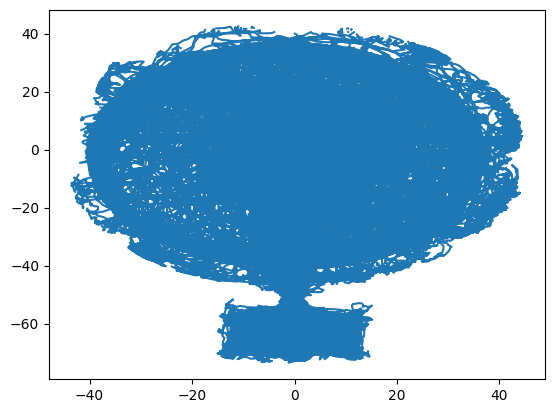

Saving original pose (shape: (499511, 7)) to /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021-0107.pose.npy
mn8578-30112021-0107
positrack2_post
Reading /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post
54047 54047 (54047, 2)
18029 18029 (72076, 2)
54051 54051 (126127, 2)
54068 54068 (180195, 2)
54037 54037 (234232, 2)
9027 9027 (243259, 2)
54041 54041 (297300, 2)
1638263295.580526 1638273984.2443635
115216.0 199687626.0
res time: 0.0 199804000.0
ROS time: 1638263295.605176 1638273984.242001 Ros duration (sec): 10688.636825084686
(499511, 7) (499511,)
mn8578-30112021-0107 /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107
task log file events from : 2021-11-30 09:54:10.694124+00:00 to 2021-11-30 11:27:57.937270+00:00
1638266050.694124 1638271677.93727
positrack file from : 2021-11-30 09:08:15.605176+00:00 to 2021-11-30 12:06:24.242001+00:00
1638263295.605176 1638273984.242001
Saving original pose (shape: (499511, 8)) to 

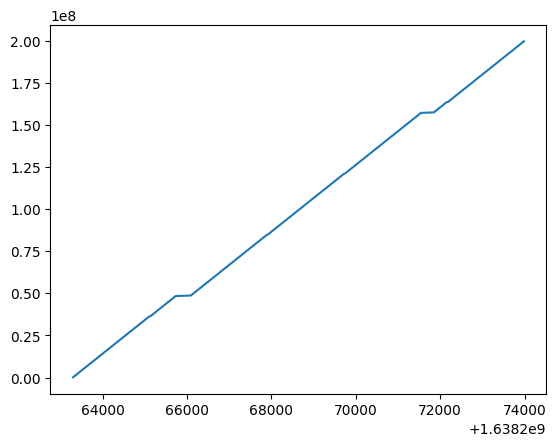

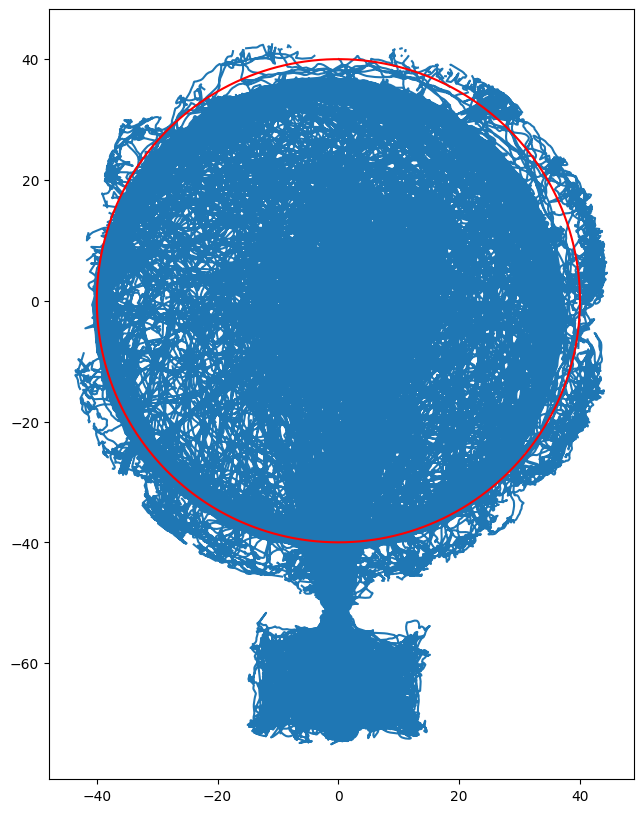

In [8]:
for i,ses in enumerate(sSessions):
    print("******",i,ses.name,"**********")
    generate_animal_pose_pose(ses)